## Neural Networks and Deep Learning

### Prajwal Luitel (C0927658)
##### 29th March 2025

# Encoder-Decoder Model for Sequence-to-Sequence Prediction in Keras



In [9]:
from random import randint
from numpy import array, argmax, array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# For reproducibility
import numpy as np
np.random.seed(42)

In [10]:
# Define the encoder-decoder model
def define_models(n_input, n_output, n_units):
    # Define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    # Define training decoder
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Training model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # Define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # Define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model

# Define the function to predict a sequence given a source
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    # Encode the input as state
    state = infenc.predict(source)
    # Prepare the start-of-sequence input (vector of zeros)
    target_seq = array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
    
    # Collect predictions
    output = list()
    for t in range(n_steps):
        yhat, h, c = infdec.predict([target_seq] + state)
        output.append(yhat[0,0,:])
        state = [h, c]
        target_seq = yhat
    return array(output)

In [11]:
# Generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(1, n_unique-1) for _ in range(length)]

# Prepare dataset for the LSTM
def get_dataset(n_in, n_out, cardinality, n_samples):
    X1, X2, y = list(), list(), list()
    for _ in range(n_samples):
        # Generate source sequence
        source = generate_sequence(n_in, cardinality)
        
        # Define target sequence: first n_out elements reversed
        target = source[:n_out]
        target.reverse()
        
        # Create padded input target sequence (prepend 0)
        target_in = [0] + target[:-1]
        
        # One-hot encode the sequences
        src_encoded = to_categorical([source], num_classes=cardinality)
        tar_encoded = to_categorical([target], num_classes=cardinality)
        tar2_encoded = to_categorical([target_in], num_classes=cardinality)
        
        # Store
        X1.append(src_encoded)
        X2.append(tar2_encoded)
        y.append(tar_encoded)
    return array(X1), array(X2), array(y)

# Decode a one-hot encoded sequence
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

In [12]:
# Configure problem parameters
n_features = 50 + 1  # cardinality
n_steps_in = 6     # length of source sequence
n_steps_out = 3    # length of target sequence

# Generate and display one sample dataset
X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
print("Shapes:", X1.shape, X2.shape, y.shape)

# Since each encoded sample has shape (1, sequence_length, cardinality), we access [0][0]
print("Source (X1) =", one_hot_decode(X1[0][0]))
print("Input Target (X2) =", one_hot_decode(X2[0][0]))
print("Expected Target (y) =", one_hot_decode(y[0][0]))

Shapes: (1, 1, 6, 51) (1, 1, 3, 51) (1, 1, 3, 51)
Source (X1) = [21, 3, 42, 4, 41, 31]
Input Target (X2) = [0, 42, 3]
Expected Target (y) = [42, 3, 21]


In [13]:
# Define the models and compile the training model
train, infenc, infdec = define_models(n_features, n_features, 128)
train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Generate training dataset (e.g., 100,000 samples)
X1_train, X2_train, y_train = get_dataset(n_steps_in, n_steps_out, n_features, 100000)
print("Training data shapes:", X1_train.shape, X2_train.shape, y_train.shape)

# Assuming X1_train, X2_train, y_train have shape (n_samples, 1, n_steps, cardinality)
X1_train = X1_train.squeeze(axis=1)
X2_train = X2_train.squeeze(axis=1)
y_train   = y_train.squeeze(axis=1)

# Now train the model
train.fit([X1_train, X2_train], y_train, epochs=1, batch_size=64)

Training data shapes: (100000, 1, 6, 51) (100000, 1, 3, 51) (100000, 1, 3, 51)
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.4558 - loss: 1.7911


In [14]:
# Evaluate the model on 100 samples
total, correct = 100, 0
for _ in range(total):
    X1_sample, X2_sample, y_sample = get_dataset(n_steps_in, n_steps_out, n_features, 1)
    # Predict target sequence using the inference models
    target_pred = predict_sequence(infenc, infdec, X1_sample[0], n_steps_out, n_features)
    
    # Compare predicted and expected target sequences
    if array_equal(one_hot_decode(y_sample[0][0]), one_hot_decode(target_pred)):
        correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━

In [15]:
# Generate a prediction example and display the results
X1_sample, X2_sample, y_sample = get_dataset(n_steps_in, n_steps_out, n_features, 1)
predicted = predict_sequence(infenc, infdec, X1_sample[0], n_steps_out, n_features)
print("Source Sequence:  ", one_hot_decode(X1_sample[0][0]))
print("Expected Target: ", one_hot_decode(y_sample[0][0]))
print("Predicted Target:", one_hot_decode(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Source Sequence:   [36, 33, 41, 40, 32, 3]
Expected Target:  [41, 33, 36]
Predicted Target: [41, 33, 36]


# Autoencoder on CIFAR-10


In [16]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import cifar10

# For reproducibility
np.random.seed(42)

In [19]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize the data to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

print('Training data shape:', x_train.shape)
print('Test data shape:', x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [21]:
# Define the convolutional autoencoder model
input_img = Input(shape=(32, 32, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Build autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/2
391/391 ━━━━━━━━━━━━━━━━━━━━ 127s 323ms/step - loss: 0.5713 - val_loss: 0.5650
Epoch 2/2
391/391 ━━━━━━━━━━━━━━━━━━━━ 117s 299ms/step - loss: 0.5623 - val_loss: 0.5617


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


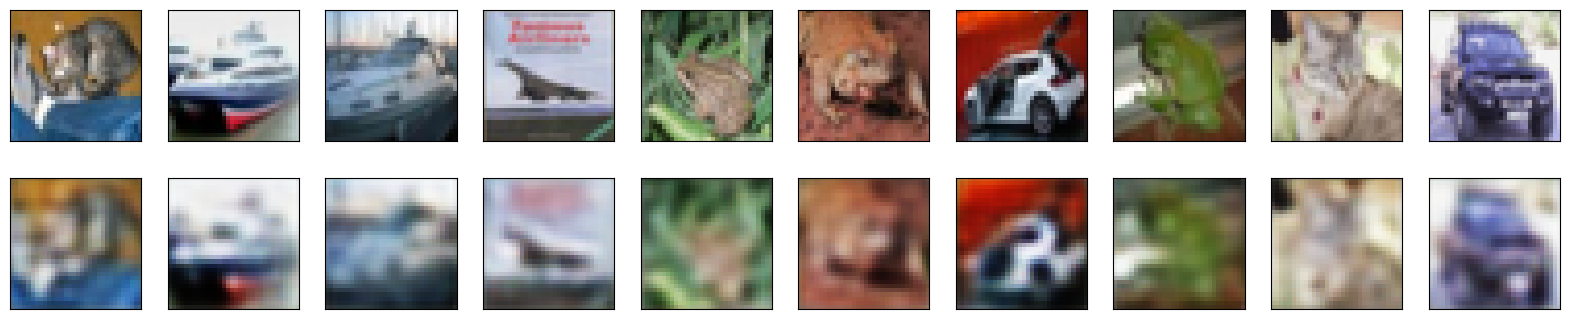

In [24]:
# Use the trained autoencoder to reconstruct the test images
decoded_imgs = autoencoder.predict(x_test)

# Number of images to display
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()